# Поиск аномалий

Методы обнаружения аномалий, как следует из названия, позволяют находить необычные объекты в выборке. Но что такое "необычные" и совпадает ли это определение у разных методов?

Начнём с поиска аномалий в текстах: научимся отличать вопросы о программировании от текстов из 20newsgroups про религию.

Подготовьте данные: в обучающую выборку возьмите 20 тысяч текстов из датасета Stack Overflow, а тестовую выборку сформируйте из 10 тысяч текстов со Stack Overflow и 100 текстов из класса soc.religion.christian датасета 20newsgroups (очень пригодится функция `fetch_20newsgroups(categories=['soc.religion.christian'])`). Тексты про программирование будем считать обычными, а тексты про религию — аномальными.

In [1]:
from datasets import load_dataset
from sklearn.datasets import fetch_20newsgroups

dataset = load_dataset("mikex86/stackoverflow-posts", split="train", streaming=True)
data_iter = iter(dataset.take(30000))

so_texts = []
for i, example in enumerate(data_iter):
    title = example.get('Title', '')
    body = example.get('Body', '')
    text = f"{title} {body}".strip()
    so_texts.append(text)


train_texts = so_texts[:20000]
test_normal_texts = so_texts[20000:30000]

religious = fetch_20newsgroups(categories=['soc.religion.christian'],
                               subset='all', shuffle=True, random_state=42)
anomaly_texts = religious.data[:100]

test_texts = test_normal_texts + anomaly_texts
test_labels = [0] * len(test_normal_texts) + [1] * len(anomaly_texts)

c:\Users\Home\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**(1 балл)**

Проверьте качество выделения аномалий (precision и recall на тестовой выборке, если считать аномалии положительным классов, а обычные тексты — отрицательным) для IsolationForest. В качестве признаков используйте TF-IDF, где словарь и IDF строятся по обучающей выборке. Не забудьте подобрать гиперпараметры.

In [2]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, make_scorer

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx, final_idx = next(sss.split(np.zeros(len(test_labels)), test_labels))

val_texts = [test_texts[i] for i in val_idx]
val_labels = [test_labels[i] for i in val_idx]
final_texts = [test_texts[i] for i in final_idx]
final_labels = [test_labels[i] for i in final_idx]

vectorizer = TfidfVectorizer(max_features=10000, min_df=2, max_df=0.8, ngram_range=(1, 2))
X_train = vectorizer.fit_transform(train_texts).astype(np.float32)
X_val = vectorizer.transform(val_texts).astype(np.float32)
X_final = vectorizer.transform(final_texts).astype(np.float32)

def anomaly_f1(y_true, y_pred):
    y_pred_bin = (y_pred == -1).astype(int)
    return f1_score(y_true, y_pred_bin)

anomaly_f1_scorer = make_scorer(anomaly_f1)

param_grid = {
    'contamination': [0.005, 0.01, 0.02, 0.05, 'auto'],
    'n_estimators': [100, 200]
}

best_score = -1
best_params = None
for contamination in param_grid['contamination']:
    for n_estimators in param_grid['n_estimators']:
        model = IsolationForest(n_estimators=n_estimators, contamination=contamination,
                                random_state=42, n_jobs=-1)
        model.fit(X_train) 
        y_val_pred = model.predict(X_val)
        score = anomaly_f1(val_labels, y_val_pred)
        print(f"contamination={contamination}, n_estimators={n_estimators}, F1 = {score:.4f}")
        if score > best_score:
            best_score = score
            best_params = {'contamination': contamination, 'n_estimators': n_estimators}

print(f"\nЛучшие параметры: {best_params}, F1 на валидации = {best_score:.4f}")

final_model = IsolationForest(**best_params, random_state=42, n_jobs=-1)
final_model.fit(X_train)

y_final_pred = final_model.predict(X_final)
y_final_bin = (y_final_pred == -1).astype(int)

precision = precision_score(final_labels, y_final_bin)
recall = recall_score(final_labels, y_final_bin)
f1 = f1_score(final_labels, y_final_bin)

print("\nРезультаты")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(classification_report(final_labels, y_final_bin, target_names=['норма', 'аномалия']))


contamination=0.005, n_estimators=100, F1 = 0.0253
contamination=0.005, n_estimators=200, F1 = 0.0811
contamination=0.01, n_estimators=100, F1 = 0.0808
contamination=0.01, n_estimators=200, F1 = 0.1042
contamination=0.02, n_estimators=100, F1 = 0.0857
contamination=0.02, n_estimators=200, F1 = 0.1102
contamination=0.05, n_estimators=100, F1 = 0.0873
contamination=0.05, n_estimators=200, F1 = 0.1343
contamination=auto, n_estimators=100, F1 = 0.0000
contamination=auto, n_estimators=200, F1 = 0.0000

Лучшие параметры: {'contamination': 0.05, 'n_estimators': 200}, F1 на валидации = 0.1343

Результаты
Precision: 0.0458
Recall:    0.2200
F1-score:  0.0759
              precision    recall  f1-score   support

       норма       0.99      0.95      0.97      5000
    аномалия       0.05      0.22      0.08        50

    accuracy                           0.95      5050
   macro avg       0.52      0.59      0.52      5050
weighted avg       0.98      0.95      0.96      5050



**(5 баллов)**

Скорее всего, качество оказалось не на высоте. Разберитесь, в чём дело:
* посмотрите на тексты, которые выделяются как аномальные, а также на слова, соответствующие их ненулевым признакам
* изучите признаки аномальных текстов
* посмотрите на тексты из обучающей выборки, ближайшие к аномальным; действительно ли они похожи по признакам?

Сделайте выводы и придумайте, как избавиться от этих проблем. Предложите варианты двух типов: (1) в рамках этих же признаков (но которые, возможно, будут считаться по другим наборам данных) и методов и (2) без ограничений на изменения. Реализуйте эти варианты и проверьте их качество.

In [3]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report

vectorizer = TfidfVectorizer(max_features=10000, min_df=2, max_df=0.8, ngram_range=(1,2))
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)


model = IsolationForest(contamination=0.01, random_state=42, n_jobs=-1)
model.fit(X_train)
preds = model.predict(X_test) 
pred_bin = (preds == -1).astype(int)
test_labels = np.array(test_labels)

fp_indices = np.where((pred_bin == 1) & (test_labels == 0))[0]
fn_indices = np.where((pred_bin == 0) & (test_labels == 1))[0]

print(f"Ложноположительных: {len(fp_indices)}")
print(f"Ложноотрицательных: {len(fn_indices)}")


print("\nПример ложноположительного (обычный текст, принят за аномалию):")
print(test_texts[fp_indices[0]][:500])

print("\nПример ложноотрицательного (аномалия, принята за норму):")
print(test_texts[fn_indices[0]][:500])


feature_names = vectorizer.get_feature_names_out()
def top_tfidf_features(text, vectorizer, top_n=10):
    vec = vectorizer.transform([text])
    scores = vec.toarray().flatten()
    top_indices = np.argsort(scores)[-top_n:][::-1]
    return [(feature_names[i], scores[i]) for i in top_indices if scores[i] > 0]

print("\nТоп-10 TF-IDF слов ложноположительного:")
for word, score in top_tfidf_features(test_texts[fp_indices[0]], vectorizer):
    print(f"  {word}: {score:.4f}")

print("\nТоп-10 TF-IDF слов ложноотрицательного:")
for word, score in top_tfidf_features(test_texts[fn_indices[0]], vectorizer):
    print(f"  {word}: {score:.4f}")


Ложноположительных: 91
Ложноотрицательных: 94

Пример ложноположительного (обычный текст, принят за аномалию):
None Once the OS is started the MBR is typically protected for virus reasons - this is one of the oldest virus tricks in the books - goes back to passing viruses from floppy to floppy.

Even if it wasn't restricted, you have to write low level code - it isn't part of the file system, but exists on a specific location on the hard drive.

Due to that, you pretty much are restricted to writing low level (most programs implement this in assembly) or C code targeting 16 bit DOS.

Most of these progra

Пример ложноотрицательного (аномалия, принята за норму):
From: sciysg@nusunix1.nus.sg (Yung Shing Gene)
Subject: Mission Aviation Fellowship
Organization: National University of Singapore
Lines: 3

Hi,
	Does anyone know anything about this group and what they
do? Any info would be appreciated. Thanks!


Топ-10 TF-IDF слов ложноположительного:
  access: 0.1963
  virus: 0.1905
  control

В обоих наборах данных присутствует большое количество общеупотребительных слов. Из-за этого модель могла посчитать аномалией техническую лексику, которая встречается редко. Если я все верно понимаю, то так и произошло.

### Эксперимент только с изменением датасета

Только с изменением: датасета можно добавить еще 10^5 текстов, которые сделают всю техническую лексику чаще.

In [4]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report
from datasets import load_dataset

dataset = load_dataset("mikex86/stackoverflow-posts", split="train", streaming=True)
data_iter = iter(dataset.take(40000))
so_texts = []
for i, example in enumerate(data_iter):
    title = example.get('Title', '')
    body = example.get('Body', '')
    text = f"{title} {body}".strip()
    so_texts.append(text)

train_texts = so_texts[:20000]
test_normal_texts = so_texts[20000:30000]

religious = fetch_20newsgroups(categories=['soc.religion.christian'], subset='all', shuffle=True, random_state=42)
anomaly_texts = religious.data[:100]
test_texts = test_normal_texts + anomaly_texts
test_labels = [0] * len(test_normal_texts) + [1] * len(anomaly_texts)

extra_iter = iter(dataset.skip(40000).take(100000))
extra_texts = []
for ex in extra_iter:
    title = ex.get('Title', '')
    body = ex.get('Body', '')
    text = f"{title} {body}".strip()
    extra_texts.append(text)

corpus_for_vectorizer = train_texts + extra_texts

vectorizer = TfidfVectorizer(max_features=10000, min_df=2, max_df=0.8,
                             ngram_range=(1,2), sublinear_tf=True)

X_vec_fit = vectorizer.fit_transform(corpus_for_vectorizer)

X_train = vectorizer.transform(train_texts)
X_test = vectorizer.transform(test_texts)

model = IsolationForest(contamination=0.05, n_estimators=200, random_state=42, n_jobs=-1)
model.fit(X_train)

y_pred = model.predict(X_test)
y_pred_bin = (y_pred == -1).astype(int)

print(classification_report(test_labels, y_pred_bin, target_names=['норма', 'аномалия']))

              precision    recall  f1-score   support

       норма       0.99      0.96      0.98     10000
    аномалия       0.08      0.36      0.13       100

    accuracy                           0.95     10100
   macro avg       0.54      0.66      0.55     10100
weighted avg       0.98      0.95      0.97     10100



Результат улучшился на не очень большое, на заметное значние.

### Эксперимент с любыми изменениями

Для улучшения приеним sentence-BERT и Local Outlier Factor с косинусным расстоянием.

In [ ]:
import numpy as np
from datasets import load_dataset
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import normalize
from sentence_transformers import SentenceTransformer

data = load_dataset("mikex86/stackoverflow-posts", split="train", streaming=True)
so = [f"{e.get('Title','')} {e.get('Body','')}".strip() for e in iter(data.take(30000))]
train, normal = so[:20000], so[20000:30000]
anom = fetch_20newsgroups(categories=['soc.religion.christian'], subset='all',
                           shuffle=True, random_state=42).data[:100]
test, labels = normal + anom, [0]*10000 + [1]*100

split = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx, fin_idx = next(split.split(np.zeros(len(labels)), labels))
val_texts, val_labels = [test[i] for i in val_idx], [labels[i] for i in val_idx]
fin_texts, fin_labels = [test[i] for i in fin_idx], [labels[i] for i in fin_idx]

enc = SentenceTransformer('all-MiniLM-L6-v2')
train_emb = normalize(enc.encode(train, batch_size=128, show_progress_bar=True))
val_emb = normalize(enc.encode(val_texts, batch_size=128, show_progress_bar=False))
fin_emb = normalize(enc.encode(fin_texts, batch_size=128, show_progress_bar=False))

best_f1, best_c = 0, 0.01
for c in (0.005, 0.01, 0.02, 0.05, 0.1):
    lof = LocalOutlierFactor(n_neighbors=10, contamination=c, metric='cosine', novelty=True).fit(train_emb)
    pred = (lof.predict(val_emb) == -1).astype(int)
    f1 = f1_score(val_labels, pred)
    if f1 > best_f1:
        best_f1, best_c = f1, c

lof = LocalOutlierFactor(n_neighbors=10, contamination=best_c, metric='cosine', novelty=True).fit(train_emb)
pred = (lof.predict(fin_emb) == -1).astype(int)
print("\nРезультаты")
print(classification_report(fin_labels, pred, target_names=['норма', 'аномалия']))

Loading weights: 100%|██████████| 103/103 [00:00<00:00, 544.33it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Batches: 100%|██████████| 157/157 [05:16<00:00,  2.01s/it]



=== Результаты ===
              precision    recall  f1-score   support

       норма       1.00      0.99      0.99      5000
    аномалия       0.47      0.90      0.62        50

    accuracy                           0.99      5050
   macro avg       0.73      0.94      0.81      5050
weighted avg       0.99      0.99      0.99      5050



Результат получился довольно неплохой

Подготовьте выборку: удалите столбцы `['id', 'date', 'price', 'zipcode']`, сформируйте обучающую и тестовую выборки по 10 тысяч домов.

Добавьте в тестовую выборку 10 новых объектов, в каждом из которых испорчен ровно один признак — например, это может быть дом из другого полушария, из далёкого прошлого или будущего, с площадью в целый штат или с таким числом этажей, что самолётам неплохо бы его облетать стороной.

Посмотрим на методы обнаружения аномалий на более простых данных — уж на табличном датасете с 19 признаками всё должно работать как надо!

Скачайте данные о стоимости домов: https://www.kaggle.com/harlfoxem/housesalesprediction/data

In [45]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score

df = pd.read_csv('kc_house_data.csv').drop(columns=['id', 'date', 'price', 'zipcode'])
df_sample = df.sample(n=20000, random_state=42).reset_index(drop=True)
train_df = df_sample.iloc[:10000].copy()
test_df = df_sample.iloc[10000:20000].copy().reset_index(drop=True)

features = train_df.columns.tolist()

np.random.seed(42)
base_indices = np.random.choice(len(test_df), size=10, replace=False)

corrupted_features = np.random.choice(features, size=10, replace=False)

inf = 100

anomalies = []
for i, feat in enumerate(corrupted_features):
    row = test_df.loc[base_indices[i]].copy()
    if feat in ['lat', 'long']:
        row[feat] = -inf
    else:
        row[feat] = inf
    anomalies.append(row)

anomalies_df = pd.DataFrame(anomalies)
anomalies_df['target'] = 1
test_df['target'] = 0
test_with_anomalies = pd.concat([test_df, anomalies_df], ignore_index=True)

X_train = train_df.values
X_test = test_with_anomalies.drop(columns='target').values
y_test = test_with_anomalies['target'].values

**Задание 9. (2 балла)**

Примените IsolationForest для поиска аномалий в этих данных, запишите их качество (как и раньше, это precision и recall). Проведите исследование:

Нарисуйте распределения всех признаков и обозначьте на этих распределениях объекты, которые признаны аномальными.


Результаты
True Positives (найдено аномалий): 0 из 10
False Positives: 8
Precision: 0.0000
Recall:    0.0000
F1-score:  0.0000

Ранги истинных аномалий:
Аномалия 0 (признак yr_built): ранг 281
Аномалия 1 (признак long): ранг 405
Аномалия 2 (признак sqft_above): ранг 3223
Аномалия 3 (признак sqft_lot15): ранг 3894
Аномалия 4 (признак bedrooms): ранг 194
Аномалия 5 (признак yr_renovated): ранг 2096
Аномалия 6 (признак sqft_living): ранг 5750
Аномалия 7 (признак grade): ранг 1259
Аномалия 8 (признак waterfront): ранг 358
Аномалия 9 (признак floors): ранг 763


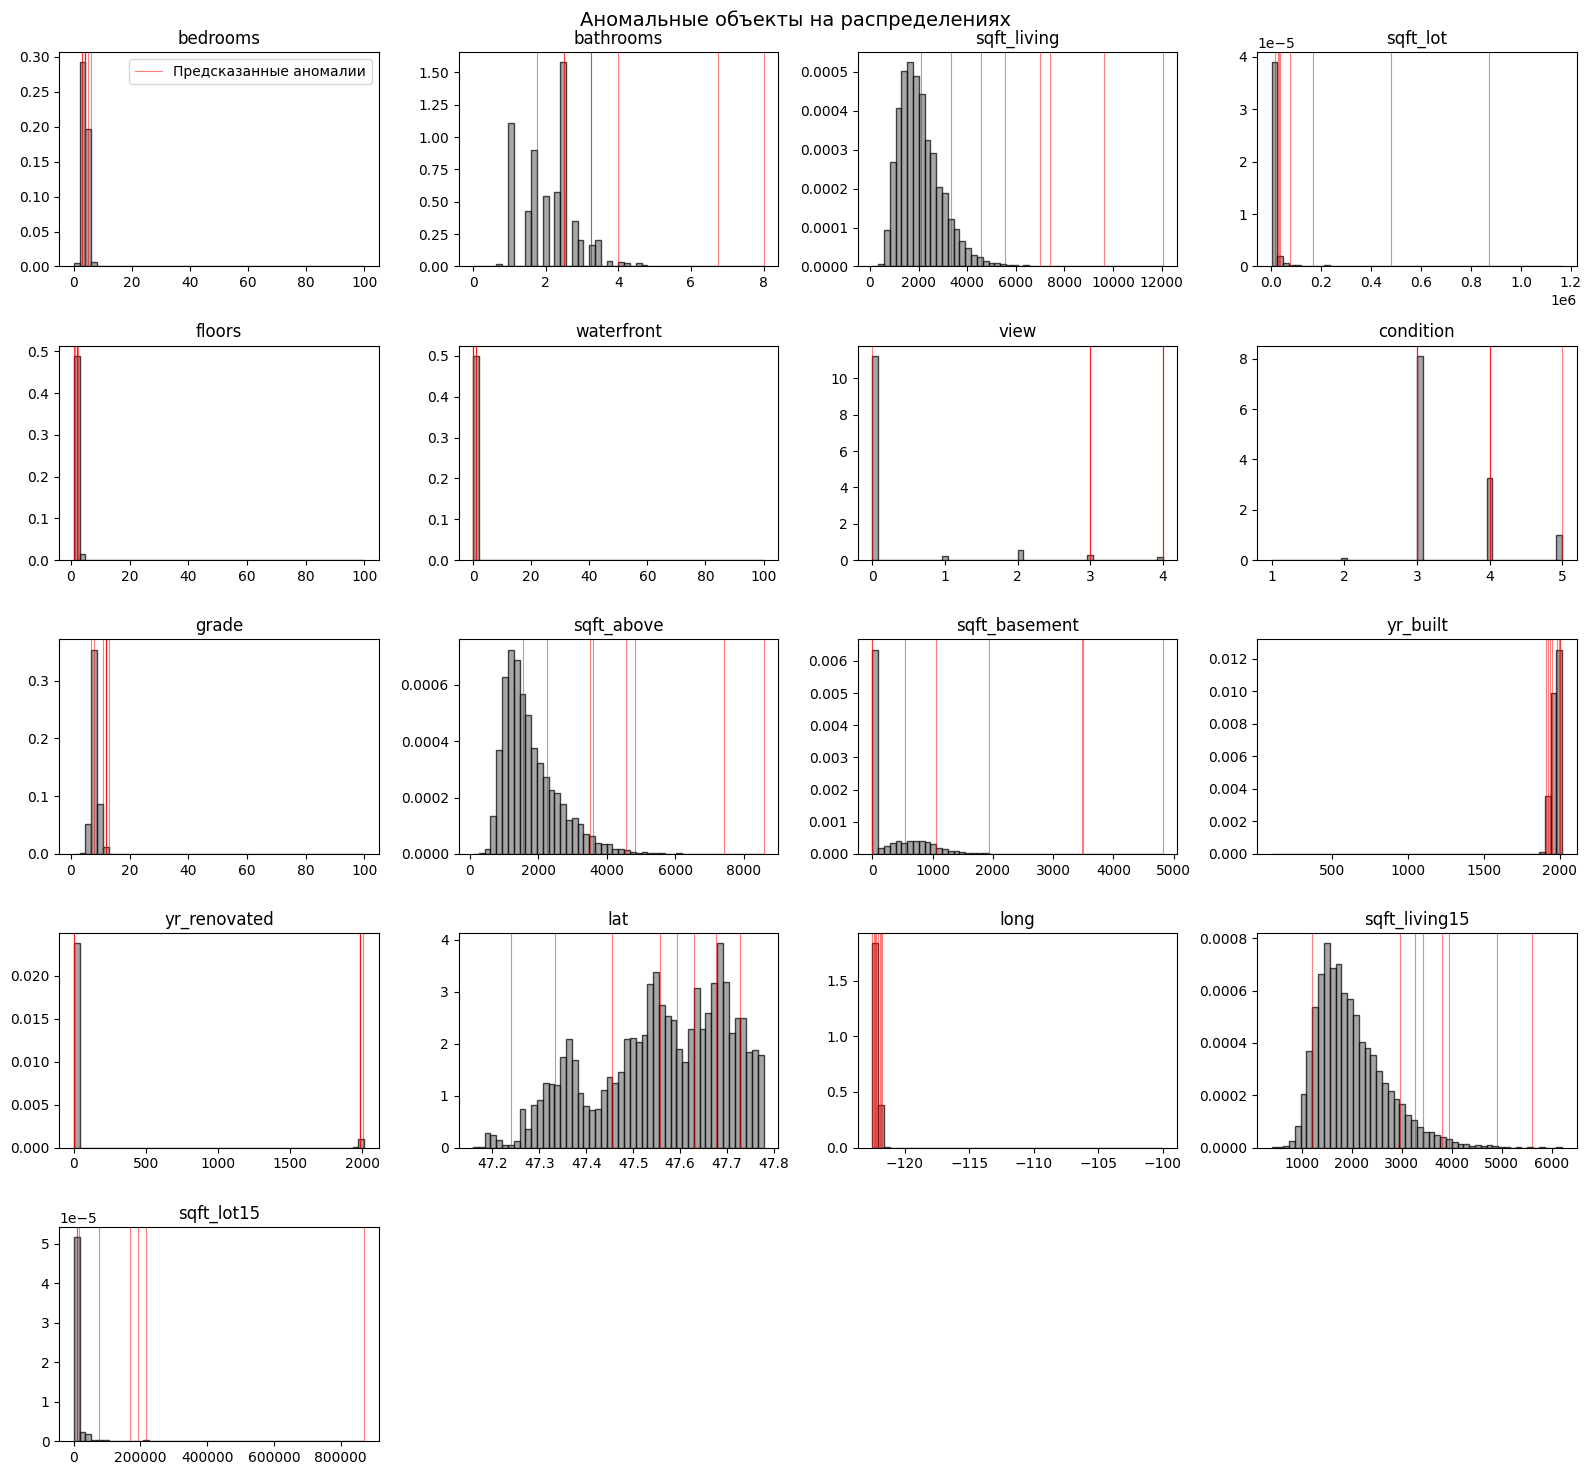

In [46]:
model = IsolationForest(
    n_estimators=1000,
    contamination=0.001,
    max_samples=1.0,
    max_features=1.0,
    bootstrap=False,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train)

y_pred = model.predict(X_test)
y_pred_bin = (y_pred == -1).astype(int)

precision = precision_score(y_test, y_pred_bin, zero_division=0)
recall = recall_score(y_test, y_pred_bin, zero_division=0)
f1 = f1_score(y_test, y_pred_bin, zero_division=0)
tp = np.sum((y_pred_bin == 1) & (y_test == 1))
fp = np.sum((y_pred_bin == 1) & (y_test == 0))

print("\nРезультаты")
print(f"True Positives (найдено аномалий): {tp} из 10")
print(f"False Positives: {fp}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")

scores = model.score_samples(X_test)
ranking = np.argsort(scores)
print("\nРанги истинных аномалий:")
for idx in np.where(y_test == 1)[0]:
    rank = np.where(ranking == idx)[0][0] + 1
    print(f"Аномалия {idx - 10000} (признак {corrupted_features[list(np.where(y_test == 1)[0]).index(idx)]}): ранг {rank}")

import matplotlib.pyplot as plt

feature_names = train_df.columns.tolist()
n_features = len(feature_names)
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 3 * n_rows))
axes = axes.flatten()

data_for_plot = test_with_anomalies.drop(columns='target')

for i, feat in enumerate(feature_names):
    ax = axes[i]
    values = data_for_plot[feat].values
    ax.hist(values, bins=50, color='gray', alpha=0.7, edgecolor='black', density=True)
    ax.set_title(feat)
    anomaly_vals = data_for_plot.loc[y_pred_bin == 1, feat]
    for val in anomaly_vals:
        ax.axvline(x=val, color='red', linewidth=0.8, alpha=0.5)
    if i == 0:
        ax.legend(['Предсказанные аномалии'], loc='upper right')

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Аномальные объекты на распределениях', fontsize=14)
plt.tight_layout()
plt.show()

Даже при изменении параметров до 10 ^ 15, объекты не считаются аномальными. Так что видимо Isolation forest плохо работает с одномерными аномалиями.